## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0717 20:56:30.773790 13428 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0717 20:56:30.775784 13428 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0717 20:56:30.838241 13428 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 20:56:30.839270 13428 deprecation_wrapper.py:119] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0717 20:56:31.270694 13428 deprecation.py:323] From C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 252us/step - loss: 15.1146 - acc: 0.2702 - val_loss: 13.9876 - val_acc: 0.3338
Epoch 2/50
50000/50000 [==============================] - 12s 235us/step - loss: 13.0478 - acc: 0.3515 - val_loss: 12.1546 - val_acc: 0.3628
Epoch 3/50
50000/50000 [==============================] - 12s 233us/step - loss: 11.3713 - acc: 0.3755 - val_loss: 10.6189 - val_acc: 0.3855
Epoch 4/50
50000/50000 [==============================] - 12s 231us/step - loss: 9.9542 - acc: 0.3924 - val_loss: 9.3145 - val_acc: 0.3998
Epoch 5/50
50000/50000 [==============================] - 12s 232us/step - loss: 8.7495 - acc: 0.4053 - val_loss: 8.2110 - val_acc: 0.4070
Epoch 6/50
50000/50000 [==============================] - 12s 233us/step - loss: 7.7238 - acc: 0.4138 - val_loss: 7.2698 - val_acc: 0.4043
Epoch 7/50
50000/50000 [==============================] - 12s 232us/step - loss: 6.8498 - acc: 0.4185 - val_lo

50000/50000 [==============================] - 11s 213us/step - loss: 2.1531 - acc: 0.2794 - val_loss: 1.9963 - val_acc: 0.3496
Epoch 2/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.9417 - acc: 0.3683 - val_loss: 1.8919 - val_acc: 0.3957
Epoch 3/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.8627 - acc: 0.3960 - val_loss: 1.8369 - val_acc: 0.4065
Epoch 4/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.8059 - acc: 0.4150 - val_loss: 1.7987 - val_acc: 0.4141
Epoch 5/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.7606 - acc: 0.4321 - val_loss: 1.7505 - val_acc: 0.4363
Epoch 6/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.7207 - acc: 0.4463 - val_loss: 1.7214 - val_acc: 0.4448
Epoch 7/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.6857 - acc: 0.4579 - val_loss: 1.6890 - val_acc: 0.4570
Epoch 8/50
50000/50000 [==============

50000/50000 [==============================] - 10s 208us/step - loss: 2.0323 - acc: 0.2735 - val_loss: 1.8613 - val_acc: 0.3506
Epoch 2/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.8089 - acc: 0.3673 - val_loss: 1.7653 - val_acc: 0.3810
Epoch 3/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.7274 - acc: 0.3967 - val_loss: 1.6980 - val_acc: 0.4116
Epoch 4/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.6690 - acc: 0.4176 - val_loss: 1.6493 - val_acc: 0.4243
Epoch 5/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.6222 - acc: 0.4336 - val_loss: 1.6047 - val_acc: 0.4370
Epoch 6/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.5806 - acc: 0.4466 - val_loss: 1.5886 - val_acc: 0.4425
Epoch 7/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.5449 - acc: 0.4588 - val_loss: 1.5447 - val_acc: 0.4530
Epoch 8/50
50000/50000 [==============

50000/50000 [==============================] - 11s 215us/step - loss: 2.0363 - acc: 0.2675 - val_loss: 1.8739 - val_acc: 0.3454
Epoch 2/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.8184 - acc: 0.3605 - val_loss: 1.7727 - val_acc: 0.3708
Epoch 3/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.7290 - acc: 0.3931 - val_loss: 1.6935 - val_acc: 0.4036
Epoch 4/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.6657 - acc: 0.4150 - val_loss: 1.6566 - val_acc: 0.4262
Epoch 5/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.6156 - acc: 0.4355 - val_loss: 1.5959 - val_acc: 0.4456
Epoch 6/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.5758 - acc: 0.4461 - val_loss: 1.5735 - val_acc: 0.4546
Epoch 7/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.5408 - acc: 0.4595 - val_loss: 1.5468 - val_acc: 0.4563
Epoch 8/50
50000/50000 [==============

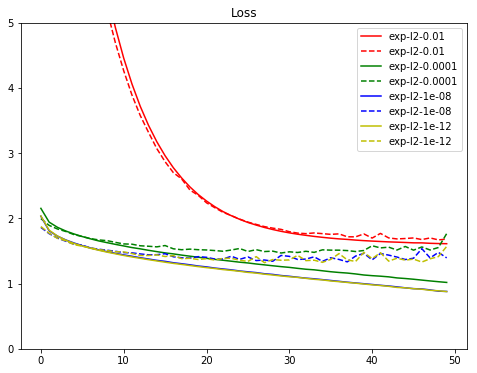

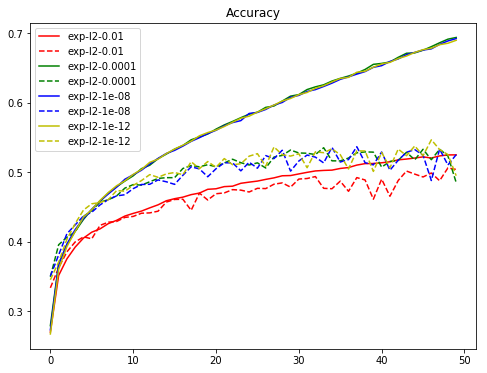

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果